1.Prepare

In [1]:
import gc
import math
import os
from dataclasses import dataclass, field

import einops
import matplotlib.pyplot as plt
import rich
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import NFKC
from tokenizers.pre_tokenizers import ByteLevel
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
def get_device(verbose: bool = False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        if verbose:
            print("Using GPU")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        if verbose:
            print("Using Apple Silicon GPU")
    else:
        device = torch.device("cpu")
        if verbose:
            print("Using CPU")
    return device

def clear_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        
def tensor_to_device(*tensors, device="cpu", non_blocking=True):
    moved = tuple(t.to(device, non_blocking=non_blocking) for t in tensors)
    return moved if len(moved) > 1 else moved[0]


def print_color(text: str, color: str = "green"):
    rich.print(f"[{color}]{text}[/{color}]")

2.Transformer Model

2.1Model Config

In [3]:
@dataclass
class ModelConfig:
    vocab_size: int = 10_000
    max_seq_len: int = 128

    d_model: int = 512
    d_ff: int = 2048
    num_heads: int = 8
    num_layers: int = 6
    dropout: float = 0.1

2.2Word Embedding

In [4]:
class WordEmbedding(nn.Module):
    def __init__(self, vocab_size:int, embed_size:int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.embedding(x)
        

2.3Position Embedding

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        pos_index = torch.arange(0, config.max_seq_len)
        div_term = torch.exp(torch.arange(0, config.d_model,2) * -(math.log(10000.0))/config.d_model)
        
        pe = torch.zeros(config.max_seq_len, config.d_model).float()
        
        pe[:, 0::2] = torch.sin(pos_index.outer(div_term))
        pe[:, 1::2] = torch.cos(pos_index.outer(div_term))
        
        pe = pe.unsqueeze(0) # Shape: (1, max_seq_len, embed_size)
        self.register_buffer("pe", pe, persistent=False)
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        seq_len = x.size(1)
        return self.pe[:, :seq_len, :] # Shape: (1, seq_len, embed_size)
        
        

2.4Layer Normalization

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, dim:int, eps:float=1e-6):
        super().__init__()
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        
        x_hat = (x-mean)/torch.sqrt(var+self.eps)
        
        return self.gamma*x_hat+self.beta
        

2.5Feed Forward Network

In [7]:
class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

2.6Multi Head Attention

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config:ModelConfig, is_causal=False):
        super().__init__()
        self.num_heads = config.num_heads
        self.head_dim = config.d_model // config.num_heads
        self.is_causal = is_causal
        
        self.q_proj = nn.Linear(config.d_model, config.d_model)
        self.k_proj = nn.Linear(config.d_model, config.d_model)
        self.v_proj = nn.Linear(config.d_model, config.d_model)
        
        self.out_proj = nn.Linear(config.d_model, config.d_model)
        
        
    def construct_mask(self, pad_mask, q_len:int, k_len:int, device):
        #"True for valid positions, False for masked positions"
        mask = None
        
        # causal mask (decoder self-attention only)
        if self.is_causal:
            mask = torch.tril(torch.ones((q_len,k_len),device=device,dtype=torch.bool))[None, None,:,:]
            
        if pad_mask is not None:
            key_valid = (~pad_mask.bool())[:,None,None,:]
            mask = key_valid if mask is None else (mask & key_valid)
        
        
        return mask
    
    def forward(self, q, k, v, mask=None):
        device = q.device
        b, q_len, _ = q.shape
        _, kv_len,_ = k.shape
        mask = self.construct_mask(mask, q_len, kv_len, device)
        
        q = self.q_proj(q).view(b,q_len,self.num_heads,self.head_dim).transpose(1,2)
        k = self.k_proj(k).view(b,kv_len,self.num_heads,self.head_dim).transpose(1,2)
        v = self.v_proj(v).view(b,kv_len,self.num_heads,self.head_dim).transpose(1,2)
        
        logits = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.head_dim)
        
        if mask is not None:
            logits = logits.masked_fill(~mask,float("-inf"))
            
        score = F.softmax(logits,dim=-1)
        attn_output = torch.matmul(score,v)
        attn_output = einops.rearrange(attn_output,"batch heads seq_len d_k -> batch seq_len (heads d_k)",)
        
        attn_output = self.out_proj(attn_output)
        
        return attn_output
            
        
        

2.7Encoder Block

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.attn = MultiHeadAttention(config, is_causal=False)
        self.ln1 = LayerNorm(config.d_model)
        
        self.ffn = FFN(config)
        self.ln2 = LayerNorm(config.d_model)
        
    def forward(self, x:torch.Tensor, mask=None)->torch.Tensor:
        attn_output = self.attn(x,x,x,mask=mask) # this means self attention
        x = self.ln1(x+attn_output)
        
        ffn_output = self.ffn(x)
        x = self.ln2(x+ffn_output)
        
        return x
        

2.8Decoder Block

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(config, is_causal=False)
        self.ln1 = LayerNorm(config.d_model)
        
        self.cross_attn = MultiHeadAttention(config, is_causal=True)
        self.ln2 = LayerNorm(config.d_model)
        
        self.ffn = FFN(config)
        self.ln3 = LayerNorm(config.d_model)
        
    def forward(
            self, 
            x:torch.Tensor, 
            enc_output:torch.Tensor, 
            src_mask=None, 
            tgt_mask=None)->torch.Tensor:
        self_attn_output = self.self_attn(x,x,x,mask=tgt_mask)
        x = self.ln1(x+self_attn_output)
        
        cross_attn_output = self.cross_attn(x,enc_output,enc_output,mask=src_mask)
        x = self.ln2(x+cross_attn_output)
        
        ffn_output = self.ffn(x)
        x = self.ln3(x+ffn_output)
        
        return x
        

2.9Encoder and Decoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(config) for _ in range(config.num_layers)])
        
    def forward(self, x:torch.Tensor, mask=None)->torch.Tensor:
        for layer in self.layers:
            x = layer(x,mask)
            
        return x
    
class Decoder(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock(config) for _ in range(config.num_layers)])
        
    def forward(
            self,
            x:torch.Tensor,
            enc_output:torch.Tensor,
            src_mask=None,
            tgt_mask=None)->torch.Tensor:
        for layer in self.layers:
            x = layer(x,enc_output,src_mask,tgt_mask)
        return x
        
        

2.10Full Model

In [12]:
class Transformer(nn.Module):
    def __init__(self, config:ModelConfig):
        super().__init__()
        
        self.vocab_embedding = WordEmbedding(config.vocab_size, config.d_model)
        self.positional_embedding = PositionalEmbedding(config)
        
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)
        
        self.output_proj = nn.Linear(config.d_model, config.vocab_size, bias=False)
        
        self.apply(self._init_weights)
        self._tie_weights()
        
    def _tie_weights(self):
        self.output_proj.weight = self.vocab_embedding.embedding.weight # their shape is equal
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
                
        elif isinstance(module, nn.Embedding):
            nn.init.xavier_normal_(module.weight)
            
        elif isinstance(module, LayerNorm):
            nn.init.ones_(module.gamma)
            nn.init.zeros_(module.beta)
    
    def forward(
            self,
            src_input:torch.Tensor,
            tgt_input:torch.Tensor,
            src_mask=None,
            tgt_mask=None)->torch.Tensor:
        src_embeddings = self.vocab_embedding(src_input)*math.sqrt( # give the input a scale
            self.vocab_embedding.embedding.embedding_dim
        )+self.positional_embedding(src_input)
        
        tgt_embeddings = self.vocab_embedding(tgt_input)*math.sqrt(
            self.vocab_embedding.embedding.embedding_dim
        )+self.positional_embedding(tgt_input)
        
        enc_output = self.encoder(src_embeddings, mask=src_mask)
        
        dec_output = self.decoder(tgt_embeddings, enc_output,src_mask = src_mask, tgt_mask=tgt_mask)
        
        logits = self.output_proj(dec_output)
        
        return logits
        
            
        

2.11A Small Example

In [13]:
DEVICE = get_device(verbose=True)

src = torch.randint(0,10000,(2,10)).to(DEVICE)
tgt = torch.randint(0,10000,(2,10)).to(DEVICE)

config = ModelConfig()

model = Transformer(config).to(DEVICE)

logits = model(src,tgt)

print(logits.shape)

Using GPU
torch.Size([2, 10, 10000])


3.Dataset Preparation

3.1Download Dataset

In [14]:
def save_dataset(dataset, file_prefix, src="en", tgt="zh", debug=True):
    assert file_prefix is not None, "file_prefix must be set"
    
    if debug:
        dataset = dataset[:len(dataset)//100]
        
    if debug:
        src_file_name = file_prefix + "_src_debug"+".txt"
        tgt_file_name = file_prefix + "_tgt_debug"+".txt"
    else:
        src_file_name = file_prefix + "_src"+".txt"
        tgt_file_name = file_prefix + "_tgt"+".txt"
        
    if os.path.exists(src_file_name) and os.path.exists(tgt_file_name):
        print(f"{src_file_name}, {tgt_file_name} already exists")
        return
    
    with (open(src_file_name, "w", encoding="utf-8") as src_f,
            open(tgt_file_name, "w", encoding="utf-8") as tgt_f,):
        for example in dataset:
            src_f.write(example[src].strip() + "\n")
            tgt_f.write(example[tgt].strip() + "\n")
    
    print(f"{src_file_name}, {tgt_file_name} saved")


dataset = load_dataset( "iwslt2017", "iwslt2017-en-zh", download_mode="force_redownload", trust_remote_code=True, )
train_dataset = dataset["train"]["translation"]
test_dataset = dataset["test"]["translation"]

save_dataset(train_dataset, file_prefix="train", debug=False)
save_dataset(test_dataset, file_prefix="test", debug=False)
        
    

Generating train split:   0%|          | 0/231266 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8549 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/879 [00:00<?, ? examples/s]

train_src.txt, train_tgt.txt already exists
test_src.txt, test_tgt.txt already exists


3.2Train BPE Tokenizer

In [15]:
def load_or_train_joint_bpe_tokenizer(
        vocab_size:int, 
        save_prefix:str,
        save_name:str="bpe_joint.json",
        src_corpus_file:str = "train_src.txt",
        tgt_corpus_file: str = "train_tgt.txt",):
    save_path = f"{save_prefix}_{save_name}"
    
    if os.path.exists(save_path):
        print(f"Loading tokenizer from {save_name}")
        return Tokenizer.from_file(save_path)
    
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = ByteLevel(add_prefix_space=True)
    tokenizer.decoder = ByteLevelDecoder()
    
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<pad>", "<unk>", "<s>", "</s>"])
    
    tokenizer.train([src_corpus_file,tgt_corpus_file],trainer)
    tokenizer.save(save_path)
    
    print(f"Saved tokenizer to {save_path}")
    
    return tokenizer


tokenizer = load_or_train_joint_bpe_tokenizer(
    vocab_size=config.vocab_size, 
    save_prefix="enzh", 
    src_corpus_file="train_src.txt", 
    tgt_corpus_file="train_tgt.txt")

Loading tokenizer from bpe_joint.json


3.3Create Dataset Class

In [16]:
def create_padding_mask(ids:torch.Tensor, pad_id:int)->torch.Tensor:
    return ids == pad_id #True = PAD

In [17]:
class TranslationDataset(Dataset):
    def __init__(self, file_prefix, tokenizer, max_seq_len =128, is_debug=True):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.is_debug = is_debug
        
        self.pad_id = tokenizer.token_to_id("<pad>") or 0
        self.sos_id = tokenizer.token_to_id("<s>") or 1
        self.eos_id = tokenizer.token_to_id("</s>") or 2
        self.source_texts, self.target_texts = self._load_text_pairs(file_prefix)
        
    def _load_text_pairs(self, file_prefix):
        src_path = file_prefix+"_src.txt"
        tgt_path = file_prefix+"_tgt.txt"
        
        assert os.path.exists(src_path), f"Source file not found: {src_path}"
        assert os.path.exists(tgt_path), f"Target file not found: {src_path}"
        
        with open(src_path, encoding="utf-8") as f_src, open(tgt_path, encoding="utf-8") as f_tgt:
            src_lines = [line.strip() for line in f_src if line.strip()]
            tgt_lines = [line.strip() for line in f_tgt if line.strip()]
        
        assert len(src_lines) == len(tgt_lines), "Mismatched number of lines in source and target files"
        
        if self.is_debug:
            src_lines = src_lines[:1000]
            tgt_lines = tgt_lines[:1000]
        return src_lines, tgt_lines
    
    def __len__(self):
        return len(self.source_texts)
    
    def __getitem__(self, idx):
        src = self.tokenizer.encode(self.source_texts[idx]).ids[:self.max_seq_len]
        tgt = self.tokenizer.encode(self.target_texts[idx]).ids[:self.max_seq_len]
        
        return {"src_ids":src, "tgt_ids":tgt}
    
def make_translation_collate_fn(pad_id:int, sos_id:int, eos_id:int, max_len:int|None=None):
    def collate(batch):
        src_list = [item["src_ids"] for item in batch]
        tgt_list = [item["tgt_ids"] for item in batch]
        
        if max_len is not None:
            src_list = [x[:max_len] for x in src_list]
            tgt_list = [x[:max_len-1] for x in tgt_list]
            
        labels_list = [t+[eos_id] for t in tgt_list] # y
        decoder_list = [[sos_id]+t for t in tgt_list] # [SOS] + y[:-1]
        decoder_list = [d[:len(l)] for d,l in zip(decoder_list, labels_list)]
        
        src_max = max(len(x) for x in src_list)
        dec_max = max(len(x) for x in decoder_list)
        
        def pad_to(x, L):
            return x+[pad_id]*(L-len(x))
        
        encoder_input_ids = torch.tensor([pad_to(x,src_max) for x in src_list], dtype = torch.long)
        decoder_input_ids = torch.tensor([pad_to(x,dec_max) for x in decoder_list], dtype = torch.long)
        labels = torch.tensor([pad_to(x,dec_max) for x in labels_list], dtype = torch.long)
        
        return {
            "encoder_input_ids":encoder_input_ids,
            "decoder_input_ids":decoder_input_ids,
            "labels":labels,
            "encoder_mask":create_padding_mask(encoder_input_ids, pad_id),
            "decoder_mask":create_padding_mask(decoder_input_ids, pad_id)
        }
    
    return collate

In [34]:
def sample(model, tokenizer):
    model.eval()
    english = "Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge."
    chinese = "几年前，在这里的 TED 上，Peter Skillman 提出了一个名为“棉花糖挑战”的设计挑战。"
    # pad engligh
    src_ids = tokenizer.encode(english).ids + [tokenizer.token_to_id("<pad>")] * (
        128 - len(tokenizer.encode(english).ids)
    )
    src_ids = torch.tensor(src_ids, dtype=torch.int64)
    src_ids = src_ids.unsqueeze(0)
    src_mask = create_padding_mask(src_ids, pad_id=tokenizer.token_to_id("<pad>"))

    # decoder_input = torch.tensor(tgt_tokenizer.encode('<s>').ids, dtype = torch.int64).unsqueeze(0)
    sos_id = tokenizer.token_to_id("<s>")
    decoder_input = torch.tensor([[sos_id]], dtype=torch.int64)

    src_ids = src_ids.to(DEVICE)
    decoder_input = decoder_input.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    while decoder_input.size(1) < 128:
        with torch.no_grad():
            out = model(src_ids, decoder_input, src_mask=src_mask)

        _, next_word = torch.max(out[:, -1], dim=-1)

        token_id = next_word.item()
        print(token_id, tokenizer.decode([token_id], skip_special_tokens=False))

        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(src_ids).fill_(next_word.item()).to(DEVICE)], dim=1
        )

        if next_word == tokenizer.token_to_id("</s>"):
            break

    output = tokenizer.decode(decoder_input[0].tolist(), skip_special_tokens=False)
    model.train()
    print_color(f"English Input: {english}", color="cyan")
    print_color(f"Chinese Output: {output}", color="cyan")
    print_color(f"Reference: {chinese}", color="cyan")

4.Start Training

4.1Training Config

In [19]:
@dataclass
class TrainConfig:
    num_epochs:int = 2
    batch_size = 256
    debug:bool = False
    total_steps:int = 10000
    warmup_steps:int=4000
    
    lr = 5e-3
    min_lr = 1e-5
    betas: tuple[float, float] = field(default_factory=lambda: (0.9,0.98))
    weight_decay:float=0.01
    
    device = get_device()
    mixed_precision:bool =True

4.2Training Loop

In [20]:
train_config = TrainConfig()

translation_dataset = TranslationDataset(
    file_prefix="train", 
    tokenizer=tokenizer, 
    max_seq_len=config.max_seq_len, 
    is_debug=False)

collate_fn = make_translation_collate_fn(
    pad_id=translation_dataset.pad_id,
    sos_id=translation_dataset.sos_id,
    eos_id=translation_dataset.eos_id,
    max_len=config.max_seq_len, 
)

train_dataloader = torch.utils.data.DataLoader(
    translation_dataset,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True if "cuda" in DEVICE.type else False,
    drop_last=False,
    collate_fn=collate_fn
)

def cycle_dataloader(dataloader):
    while True:
        for batch in dataloader:
            yield batch
            
dataloader = cycle_dataloader(train_dataloader)

In [21]:
train_config.total_steps = train_config.num_epochs*math.ceil(
    len(translation_dataset)/train_config.batch_size
)

4.2.1Learning Rate Scheduler

In [22]:
class TransformerLRScheduler:
    def __init__(self, optimizer, d_model:int, warmup_steps:int =4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num=0
        
    def step(self):
        self.step_num+=1
        lr = (self.d_model**-0.5)*min(self.step_num**-0.5, self.step_num*(self.warmup_steps**-1.5))
        
        for pg in self.optimizer.param_groups:
            pg["lr"]=lr
            
        return lr
        

4.2.2Start Training Transformer


In [23]:
model_config = ModelConfig()
model = Transformer(model_config)
model = model.to(train_config.device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.0, ignore_index=translation_dataset.pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr = train_config.lr, betas=train_config.betas, eps=1e-9)
scheduler = TransformerLRScheduler(optimizer, 
                                   d_model=model_config.d_model, warmup_steps= train_config.warmup_steps)

print("Start training")
losses=[]

step=0
for epoch in range(train_config.num_epochs):
    p_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{train_config.num_epochs}")
    epoch_loss=0.0
    
    for batch in p_bar:
        step+=1
        optimizer.zero_grad()
        
        # ----------------------------------------
        # One training step
        # ----------------------------------------
        encoder_input_ids = batch["encoder_input_ids"].to(train_config.device)
        decoder_input_ids = batch["decoder_input_ids"].to(train_config.device)
        enc_mask = batch["encoder_mask"].to(train_config.device)
        dec_mask = batch["decoder_mask"].to(train_config.device)
        labels = batch["labels"].to(train_config.device)
        
        with torch.autocast(
            device_type=train_config.device.type, enabled=train_config.mixed_precision, dtype=torch.bfloat16
        ):
            logits = model(encoder_input_ids, decoder_input_ids, src_mask=enc_mask, tgt_mask = dec_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        
        # ----------------------------------------
        # Update parameters
        # ----------------------------------------
        lr = scheduler.step()
        nn.utils.clip_grad_norm_(model.parameters(),2.0)
        optimizer.step()
        
        # ----------------------------------------
        # Log training information
        # ----------------------------------------
        epoch_loss += loss.item()
        losses.append(loss.item())
        
        p_bar.set_postfix({"loss": f"{loss.item():.4f}", "lr": f"{lr:.6f}"})
        
        del loss, logits, encoder_input_ids, decoder_input_ids, enc_mask, dec_mask, labels
        clear_cuda()
        
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print_color(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

Start training


Epoch 1/2: 100%|████| 904/904 [08:46<00:00,  1.72it/s, loss=0.2465, lr=0.000158]


Epoch 1 completed. Average Loss: 5.2894

Epoch 2/2: 100%|████| 904/904 [08:46<00:00,  1.72it/s, loss=0.0315, lr=0.000316]


Epoch 2 completed. Average Loss: 0.0447

4.3Plot Loss

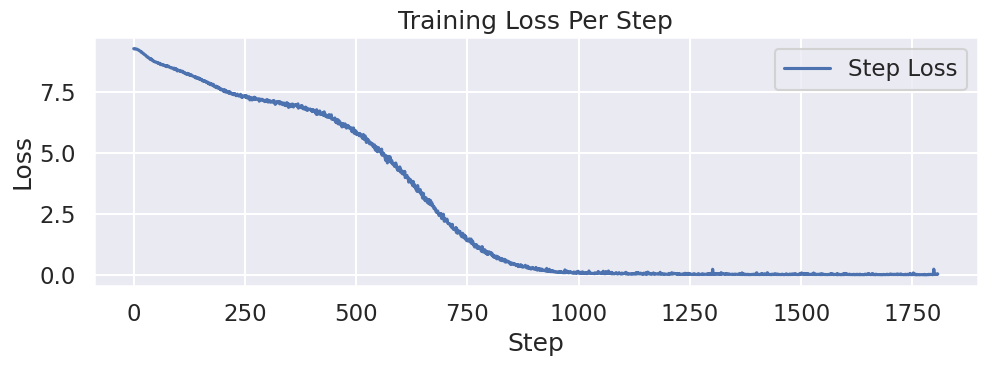

In [24]:
sns.set_theme()
sns.set_context("talk")  # larger labels
plt.figure(figsize=(10, 4))
plt.plot(losses, label="Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Per Step")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")  # high-res PNG
plt.show()

In [35]:
sample(model, tokenizer)

3 </s>


English Input: Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow
challenge.

Chinese Output: <s></s>

Reference: 几年前，在这里的 TED 上，Peter Skillman 提出了一个名为“棉花糖挑战”的设计挑战。

In [32]:
print(tokenizer.encode("棉花糖挑战").tokens)
print(tokenizer.encode("棉花糖挑战").ids)


['Ġæ', '£', 'ī', 'èĬ±', 'ç³ĸ', 'æĮĳæĪĺ']
[352, 96, 154, 1504, 5385, 4502]


In [33]:
print("pad_id:", tokenizer.token_to_id("<pad>"))

pad_id: 0


TODO: Need to solve the translation problem